# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
#======================================================================================#
#                              Import Libraries                                        #
#======================================================================================#
# import libraries here; add more as necessary
import sklearn 
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler,MinMaxScaler,RobustScaler
import pickle
from sklearn.cluster import KMeans
from timeit import default_timer as timer
print (" Sklearn Version: ",sklearn.__version__)
from helpers import *
from IPython.display import Image
from sklearn.metrics import silhouette_samples, silhouette_score
import collections
from IPython.display import display
import gc
# magic word for producing visualizations in notebook
%matplotlib inline

 Sklearn Version:  0.19.1


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
startProgram = timer() 

In [3]:
# Load in the general demographics and feature summary file. 
def loadData(): 
    print ("\nLoading Data....")
    missing_values_azdias = ['-1',"''",'X','XX']
    azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';', na_values = missing_values_azdias)

    missing_values_feat_info =  ['[X]','[XX]','[]','[-1,X]','[-1,XX]']
    feat_info  = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';', na_values = missing_values_feat_info)
    print ("General demographic data loaded. Shape: ", azdias.shape)
    return azdias, feat_info

In [4]:
azdias, feat_info = loadData()
print (azdias.shape)
display (azdias.head())


Loading Data....
General demographic data loaded. Shape:  (891221, 85)
(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
def loadCustomerData(): 
    print ("\nLoading Data....")
    missing_values_azdias = ['-1',"''",'X','XX']
    customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';', na_values = missing_values_azdias)
    print ("Customer data loaded.")
    return customer

Missing values are being filtered here. '-1' is always a missing value, along with "''". This is the easiest place to filter. 

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows). Shape and Head.
print ("=" * 110)
print ('Demographics data file for {} persons and {} features. \n'.format(azdias.shape[0], azdias.shape[1]))

display (azdias.head(3))
print ("=" * 110)

print ('Feature Summary file has {} features and {} attributes:'.format(feat_info.shape[0], feat_info.shape[1]))
display (feat_info.head(3))
print ("=" * 110)

Demographics data file for 891221 persons and 85 features. 



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


Feature Summary file has 85 features and 4 attributes:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Convert missing value codes from string to float list
def translate():
    print ("\nConverting feat_info missing value strings to float....")
    column_names = ['attribute','value']
    nancodes = pd.DataFrame(columns = column_names)

    for index, value in feat_info['missing_or_unknown'].items():
        if type(value) == str:
            value = value.translate(str.maketrans({'[':None,']':None})).split(',')
            for num  in range(len(value)):
                value[num] = float(value[num])
        
    # for missing values convert to [-1] so they are captured in column summaries:
    
        if type(value) == np.nan:
            value = [-1]
        nancodes.loc[index] = [feat_info['attribute'][index],value]
    
    nancodes.set_index('attribute',inplace=True)
    #nancodes.head(3)
    return nancodes

In [8]:
nancodes = translate()
nancodes.head() 


Converting feat_info missing value strings to float....


,value
attribute,
AGER_TYP,"[-1.0, 0.0]"
ALTERSKATEGORIE_GROB,"[-1.0, 0.0, 9.0]"
ANREDE_KZ,"[-1.0, 0.0]"
CJT_GESAMTTYP,[0.0]
FINANZ_MINIMALIST,[-1.0]


In [9]:
    # For validation:
    print ("\nSelecting cells for missing value replacement.....")
    print (azdias['AGER_TYP'][0])
    print (azdias['ARBEIT'][4158])
    print (azdias['CAMEO_DEUG_2015'][2511])


Selecting cells for missing value replacement.....
nan
9.0
nan


In [10]:
def values_to_codes(df_main, df_lookup):
    print ("\nReplacing dataframe missing values with np.nan...")
    for column in df_main.columns: 
        if column in df_lookup.index: 
            #print (column, df_lookup.loc[column][0])
            df_main[column] = df_main[column].replace(nancodes.loc[column][0], np.nan)
 
        else:
            pass
    return df_main

In [11]:
azdias = values_to_codes(azdias,nancodes)


Replacing dataframe missing values with np.nan...


In [12]:
    print ("Validating nan replacement....")
    print (azdias['AGER_TYP'][0])
    print (azdias['ARBEIT'][4158])
    print (azdias['CAMEO_DEUG_2015'][2511])

Validating nan replacement....
nan
nan
nan


The 9.0 was succesfully converted to 'nan'. 

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
#Calulating the number of missing values per column using isnull. 
def count_columns(df): 
    print ("\nCounting the number of missing values per column....")
    total_missing_values_by_column = df.isnull().sum()  
    col_nan_count = total_missing_values_by_column.to_frame('Count_NaN')
    col_nan_count.insert(loc=0,column='Column Name',value = col_nan_count.index)
    col_nan_count = col_nan_count.reset_index(drop=True)
    col_nan_count = col_nan_count.sort_values(by = 'Count_NaN',ascending = False)
    display (col_nan_count.head(3))
    return col_nan_count,total_missing_values_by_column

In [14]:
col_nan_count, total_missing_values_by_column = count_columns(azdias)


Counting the number of missing values per column....


,Column Name,Count_NaN
40,TITEL_KZ,889061
0,AGER_TYP,685843
47,KK_KUNDENTYP,584612


In [15]:
def plot_missing_by_cols(totals): 
    #Histogram of the number of missing values per column (featrure).
    xref = [40000,200000]
    ref_colors=['r','g','y']

    for ref, c in zip(xref,ref_colors):
        plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
    plt.legend()
    plt.grid(True)
    plt.xlabel('Count of NaN')
    plt.ylabel('Number of Columns')
    plt.title('Distibution of Missing Values by Column')
    plt.hist(totals.values,50)
    plt.show()

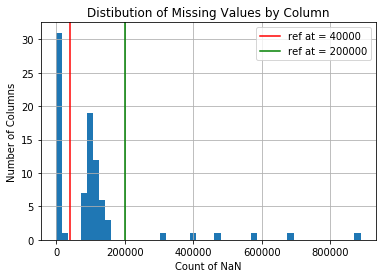

In [16]:
plot_missing_by_cols(total_missing_values_by_column)


Below is a sorted, ascending list of unique column counts. There are 53 columns with NaN and only 16 unique counts.  The data is not randomly distributed and there is clustering. 

In [17]:

def dropColumns(df,limit):
    print ("\nDropping outlier columns from the dataset per limit.....")
    drop_columns = list(df.isnull().sum()[df.isnull().sum()>limit].index)
    print ("Number of columns in dropped list: ",len(drop_columns))
    print ("Before dropping: ",df.shape)
    df = df.drop(drop_columns, axis = 1)
    print ("After dropping: ",df.shape)
    return df

In [18]:
azdias = dropColumns(azdias,200000)


Dropping outlier columns from the dataset per limit.....
Number of columns in dropped list:  6
Before dropping:  (891221, 85)
After dropping:  (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

Since I filtered the incoming data, fewer columns than typical are dropped. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [19]:
def countRows(df):
    # Missing data in each row of the dataset
    row_total = df.isnull().sum(axis=1)
    row_total[np.isfinite(row_total)]
    row_nan_count = row_total.to_frame('Count_NaN')
    row_nan_count.insert(loc=0,column='Row',value = row_nan_count.index)
    row_nan_count = row_nan_count.reset_index(drop=True)
    row_nan_count = row_nan_count.sort_values(by = 'Count_NaN',ascending = False)
    print (row_nan_count.shape)
    #display (row_nan_count.head())
    return row_nan_count, row_total 

In [20]:
row_nan_count, row_total = countRows(azdias)

(891221, 2)


 How much data is missing in each row of the dataset? Will be summarized in a histogram instead. 

In [21]:
# How much data is missing in each row of the dataset? 
# Shown as historgram. 

def plot_rowCount(rowcount): 
    xref = [25]
    ref_colors=['y']

    for ref, c in zip(xref,ref_colors):
        plt.axvline(x=ref, c=c, label= 'limit at = {}'.format(ref))
    plt.legend()
    plt.grid(True)
    plt.xlabel('Count of NaN')
    plt.ylabel('Rows')
    plt.title('Distibution of Missing Values by Row')
    plt.hist(rowcount['Count_NaN'],50)
    plt.show()

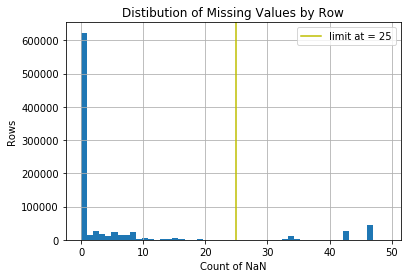

In [22]:
plot_rowCount(row_nan_count)

In [23]:
# Spliting the rows into hi and low values for missing data: 

def split_rows(limit):
    nan_rowcount = azdias.isnull().sum(axis=1)
    
    rows_lower = nan_rowcount[nan_rowcount <= limit]
    rows_higher = nan_rowcount[nan_rowcount > limit]
    print('rows with higher missing values:', rows_higher.shape[0], 'or', \
      np.round(rows_higher.shape[0]*100/nan_rowcount.shape[0],2), '% ')
    print('rows with lower missing values:', rows_lower.shape[0], 'or', \
      np.round(rows_lower.shape[0]*100/nan_rowcount.shape[0],2), '% ')
    return nan_rowcount, rows_lower,rows_higher

In [24]:
nan_rowcount, rows_lower, rows_higher = split_rows(25)

rows with higher missing values: 93260 or 10.46 % 
rows with lower missing values: 797961 or 89.54 % 


In [25]:
#for the 2 subsets of rows, filter by columns with low or no failures: 

def rows_filterBy_col(column): 
    rows_lower_colfilter = azdias.loc[rows_lower.index,column]
    rows_higher_colfilter = azdias.loc[rows_higher.index,column]
    rows_lower_colfilter = rows_lower_colfilter[np.isfinite(rows_lower_colfilter)]
    rows_higher_colfilter = rows_higher_colfilter[np.isfinite(rows_higher_colfilter)]
    #print ("rows_lower_colfilter: \n",rows_lower_colfilter[:30])
    #print ("\nrows_higher_colfilter:\n ",rows_higher_colfilter[:30] )
    return column, rows_lower_colfilter, rows_higher_colfilter

In [26]:
column, rows_lower_colfilter, rows_higher_colfilter = rows_filterBy_col('ALTERSKATEGORIE_GROB')

In [27]:
df_col1 = rows_filterBy_col('ALTERSKATEGORIE_GROB')
df_col2 = rows_filterBy_col('FINANZTYP')
df_col3 = rows_filterBy_col('FINANZ_UNAUFFAELLIGER')
df_col4 = rows_filterBy_col('FINANZ_SPARER')
df_col5 = rows_filterBy_col('FINANZ_HAUSBAUER')
df_col6 = rows_filterBy_col('FINANZ_MINIMALIST')

In [28]:

#defining function to compare missing values in specified column
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
def make_histos(df_col1,df_col2,df_col3,df_col4,df_col5,df_col6):
   
    bins = 20
    bins = np.linspace(0, 10, 50)
    
    column1, df1, df2 = df_col1
    column2, df3, df4 = df_col2
    column3, df5, df6 = df_col3
    column4, df7, df8 = df_col4
    column5, df9, df10 = df_col5
    column6, df11, df12 = df_col6

    fig, ax = plt.subplots(2,3, sharex=True,sharey=True,figsize=(14,4),gridspec_kw={'hspace': 0.3})
    
    ax0, ax1,ax2,ax3,ax4,ax5 = ax.flatten()
     
    ax0.hist(df1,bins,label='Lower',histtype='bar',stacked = False)
    ax0.hist(df2,bins,label='Higher',histtype='bar', stacked = False)
    ax0.set_title('Category: ' + column1)
    ax0.legend(loc='upper right')
    ax0.grid(True)
    
    ax1.hist(df3,bins,label='Lower',stacked = False)
    ax1.hist(df4,bins,label='Higher',stacked = False)
    ax1.set_title('Category: ' + column2)
    ax1.legend(loc='upper right')
    ax1.grid(True)
    
    ax2.hist(df5,bins,label='Lower',stacked = False)
    ax2.hist(df6,bins,label='Higher',stacked = False)
    ax2.set_title('Category: ' + column3)
    ax2.legend(loc='upper right')
    ax2.grid(True)
        
    ax3.hist(df7,bins,label='Lower',stacked = False)
    ax3.hist(df8,bins,label='Higher',stacked = False)
    ax3.set_title('Category: ' + column4)
    ax3.legend(loc='upper right')
    ax3.grid(True)
    
    ax4.hist(df9,bins,label='Lower',stacked = False)
    ax4.hist(df10,bins,label='Higher',stacked = False)
    ax4.set_title('Category: ' + column5)
    ax4.legend(loc='upper right')
    ax4.grid(True)
    
    ax5.hist(df11,bins,label='Lower',stacked = False)
    ax5.hist(df12,bins,label='Higher',stacked = False)
    ax5.set_title('Category: ' + column6)
    ax5.legend(loc='upper right')
    ax5.grid(True)
    
    plt.subplots_adjust(wspace= 0.1)
    plt.legend(loc='upper right')
 
    fig.text(0.5,0.04,'Category Code', ha='center')
    fig.text(0.04,0.5,'Number of Rows', va='center', rotation='vertical')
    plt.show()
    return

#figure, axs = plt.subplots(nrows=len(compare_columns), ncols=2, figsize = (15,20))
#figure.subplots_adjust(hspace = 1, wspace=.3)

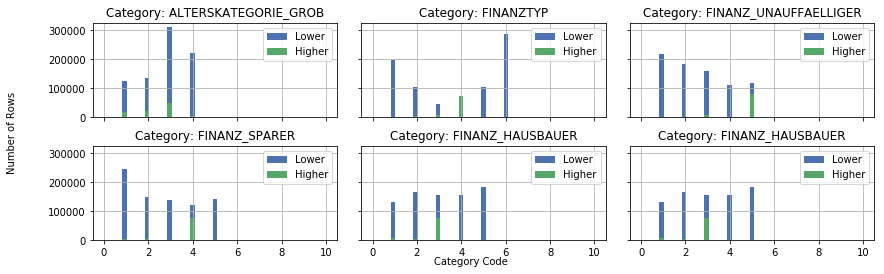

In [29]:
make_histos(df_col1,df_col2,df_col3,df_col4,df_col5,df_col5)

In [30]:
def dropRows(df,limit):
    print ("\nDropping outlier rows from the dataset per limit.....")
    print ("\nBefore dropping: ",df.shape)
    nan_rowcount = df.isnull().sum(axis=1)
    #plot_rowCount(nan_rowcount)
    drop_rows  = nan_rowcount[nan_rowcount > limit]
    #print ("drop_rows: ",drop_rows)
    #print (drop_rows.index)
    print ("Number of rows in dropped list: ",len(drop_rows))
    df_drop = df.drop(drop_rows.index, axis = 0)
    print ("After dropping: ",df_drop.shape)
    return df_drop

In [31]:
azdias = dropRows(azdias,25)


Dropping outlier rows from the dataset per limit.....

Before dropping:  (891221, 79)
Number of rows in dropped list:  93260
After dropping:  (797961, 79)


#### Discussion 1.1.3: Assess Missing Data in Each Row

 Some columns have similarites,ALTERSKATEGORIE_GROB or estimated age, has the highest number for bin 3, or 46-60 year olds, although the magnitude for the rows with fewer missing values is much greater. However, for FINANZ_MINIMALIST, the largest bucket is for '1' which is 'very high' while for higher missing values '5' has the largest number, compared to the other bins. So in these case it looks different. 
 
 in general, the rows with fewer missing values have more data so the magnitude of the 'Lower' bars is greater. The next step would be to plot in percent to see how much difference there is. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# How many features are there of each data type?
display (feat_info.head(3))
display (feat_info['type'].value_counts())

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
#azdias,feat_info = reLoad(azdias,feat_info)

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Use Feat_info to identify columns with categorical data: 
def create_binary_multi_categories(df_main, df_lookup):
    category_columns = df_lookup.loc[df_lookup['type'] == 'categorical']
    #print (category_columns[:3])
    multi_categorical = []
    binary_categorical = []
    for column in category_columns['attribute']:
        if column in df_main:
            if df_main[column].nunique() <= 2:
                #print ("\ncolumn binary: ",column, "nunique: ",df_main[column].nunique())
                binary_categorical.append(column)
            else:
                #print ("\ncolumn multi: ",column, "nunique: ",df_main[column].nunique())
                multi_categorical.append(column) 
    print ("\nNumber of multi categorical variables: {} and Number of binary categorical variables: {}\n".format \
       (len(multi_categorical),len(binary_categorical)))
    #print ("Binary Categorical Columns: \n",binary_categorical)
    #print ("\nMulti Categorical Columns: \n",multi_categorical)
    return binary_categorical, multi_categorical

In [35]:
binary_categorical, multi_categorical = create_binary_multi_categories(azdias,feat_info)


Number of multi categorical variables: 13 and Number of binary categorical variables: 5



In [36]:
# Re-encode categorical variable(s) to be kept in the analysis.
def list_binary_multi_categories(df,bin_cat,multi_cat): 
    print ("Binary: \n")
    for column in bin_cat :
        print (column,df[column].unique())
    print ("-----" *20)
    print ("Number of Multi:\n")
    for column in multi_cat :
        print (column,df[column].unique())

In [37]:
list_binary_multi_categories(azdias,binary_categorical,multi_categorical)

Binary: 

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
VERS_TYP [  2.   1.  nan]
OST_WEST_KZ ['W' 'O']
----------------------------------------------------------------------------------------------------
Number of Multi:

CJT_GESAMTTYP [  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP [1 6 5 2 4 3]
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
LP_FAMILIE_FEIN [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ [  1.   3.   2.  nan]
SHOPPER_TYP [  3.   2.   1.   0.  nan]
ZABEOTYP [5 3 4 1 6 2]
GEBAEUDETYP [ 8.  1.  3.  2.  6.  4.  5.]
CAMEO_DEUG_2015 [  8.   4.   2.   6.   1.   9.   5.   7.  nan   3.]
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '

In [38]:
def encode_binary(df):
 print ("\nBefore Replacement: ",df['OST_WEST_KZ'].unique())
 df['OST_WEST_KZ'].replace(['W','O'], [1.0,0.0], inplace=True)
 print ("After Replacement: ",df['OST_WEST_KZ'].unique())
 return df

In [39]:
azdias = encode_binary(azdias)


Before Replacement:  ['W' 'O']
After Replacement:  [ 1.  0.]


All binary list being replaced with [1,2]. Along with '-1', '0' reserved for unknown. 

In [40]:
def encode_multi(df,multi):
    print ("\nbefore dummies", df.shape)
    df = pd.get_dummies(df, columns = multi)
    print ("after dummy column insertion", df.shape)
    return df

In [41]:
azdias = encode_multi(azdias,multi_categorical)


before dummies (797961, 79)
after dummy column insertion (797961, 194)


#### Discussion 1.2.1: Re-Encode Categorical Features

All binary list being replaced with [1,2].  The variables  '-1' and  '0' reserved for unknown. ANREDE_KZ was left untouched as it was correctly formatted. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [42]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# New variable decade with value corresponding to decade: 

#generation encoded as '1' for mainstream and '2' for Avantgarde 

def generation(value):
    decades = {0:np.nan,1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}
    gen = decades[value]
    return gen

def movement(value):
    movements = {0:np.nan,1:1,2:2,3:1,4:2,5:1,6:2,7:2,8:1,9:2,10:3,11:2,12:1,13:2,14:1,15:2}
    gen = movements[value]
    return gen

#azdias["Generation"] = azdias['PRAEGENDE_JUGENDJAHRE'].fillna(0).apply(generation)
#azdias["Movement"] = azdias['PRAEGENDE_JUGENDJAHRE'].fillna(0).apply(movement)

#print (azdias[['PRAEGENDE_JUGENDJAHRE','Generation','Movement']].head(7))

In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def wealth(value):
    if value == 'XX':
        return np.nan
    if pd.isnull(value):
        return np.nan
    else:
        return int(str(value)[0])

def lifestage(value):
    if value == 'XX':
        return np.nan
    if pd.isnull(value):
        return np.nan
    else:
        return int(str(value)[1])

In [44]:
def newVariables(df): 
    print ("adding new variables..", df.shape)
    df["Generation"] = df['PRAEGENDE_JUGENDJAHRE'].fillna(0).apply(generation)
    df["Movement"] = df['PRAEGENDE_JUGENDJAHRE'].fillna(0).apply(movement)
    df['CAMEO_Wealth'] = df['CAMEO_INTL_2015'].apply(wealth)
    df['CAMEO_Lifestage'] = df['CAMEO_INTL_2015'].apply(lifestage)
    
    print ("Shape after new variables: ",df.shape)
    print (df[['CAMEO_INTL_2015','CAMEO_Wealth','CAMEO_Lifestage']].head())
    print (df[['PRAEGENDE_JUGENDJAHRE','Generation','Movement']].head())

    return df 

In [45]:

print (azdias.shape)
azdias = newVariables(azdias)
print ("After newVariables:",azdias.shape)


(797961, 194)
adding new variables.. (797961, 194)
Shape after new variables:  (797961, 198)
   CAMEO_INTL_2015  CAMEO_Wealth  CAMEO_Lifestage
1             51.0           5.0              1.0
2             24.0           2.0              4.0
3             12.0           1.0              2.0
4             43.0           4.0              3.0
5             54.0           5.0              4.0
   PRAEGENDE_JUGENDJAHRE  Generation  Movement
1                   14.0        90.0       1.0
2                   15.0        90.0       2.0
3                    8.0        70.0       1.0
4                    8.0        70.0       1.0
5                    3.0        50.0       1.0
After newVariables: (797961, 198)


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [46]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
def excludeOriginalColumns(df):
    print ("\nBefore excluding columns", df.shape)
    if set(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']).issubset(df.columns):
       df = df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1)
    print ("After excluding columns", df.shape)
    return df

In [47]:
azdias = excludeOriginalColumns(azdias) 


Before excluding columns (797961, 198)
After excluding columns (797961, 196)


In [48]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [49]:
def myimpute(df):
    print ("Starting Imputer Shape: ",df.shape)
    percent = 100*(df.isnull().sum().sum()/(df.shape[0]*df.shape[1]))
    print ("\nThe total number of missing values before imputing is: {} or {:.1f}%. \
       .".format(df.isnull().sum().sum(),percent))
    imputer = Imputer(missing_values = 'NaN',strategy='most_frequent')

    df_cleaned_impute = pd.DataFrame(imputer.fit_transform(df))
                                     
    df_cleaned_impute.columns = df.columns
    df_cleaned_impute.index = df.index
                                     
    print ("Final Cleaned, Imputed Shape: ",df_cleaned_impute.shape)
    #display (azdias_cleaned_impute.head())
    #print ("\nMissing Values After Imputing: ",df_cleaned_impute.isnull().sum().sum())
    print ("\n Imputing completed.")
    return df_cleaned_impute 

In [50]:
def clean_data1(df,column_limit):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame. Column Limit. 
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    start = timer()
    
    # Convert feat_info missing value codes to np.nan: 
    nancodes = translate()
    
    # With corrected feat_info (nancodes), convert nan codes to np.nan 
    df_missing_codes_replaced = values_to_codes(df,nancodes)
    print (df_missing_codes_replaced.shape)
    df_missing_codes_replaced.head()
    
    #count the number of missing values per column:
    col_nan_count, total_missing_values_by_column = count_columns(df_missing_codes_replaced)
   
    # Use plot to define limit for the number of missing values allowed per column.
    plot_missing_by_cols(total_missing_values_by_column)
    
    # Drop columns above limit 
    df_columns_dropped = dropColumns(df_missing_codes_replaced,column_limit)
    print (df_missing_codes_replaced.shape)
    
    row_nan_count, row_total = countRows(df_columns_dropped)

    plot_rowCount(row_nan_count)
    
    df_rows_dropped = dropRows(df_columns_dropped,25)
    print ("After dropping rows: ",df_rows_dropped.shape)
    
    binary_categorical, multi_categorical = create_binary_multi_categories(df_rows_dropped,feat_info)

    #list_binary_multi_categories(azdias,binary_categorical,multi_categorical)
    
    df_rows_dropped = encode_binary(df_rows_dropped)
    
    df_encoded = encode_multi(df_rows_dropped,multi_categorical)
    
    df_encoded = newVariables(df_encoded)

    df_imputed = myimpute(df_encoded) 
    df_columns_excluded = excludeOriginalColumns(df_imputed) 

    print ("\nEnd of cleaning. ")
    end = timer()
    print(f"\nCleaned data in {end - start:0.0f} seconds")
    
    return df_columns_excluded 


Loading Data....
General demographic data loaded. Shape:  (891221, 85)

Converting feat_info missing value strings to float....

Replacing dataframe missing values with np.nan...
(891221, 85)

Counting the number of missing values per column....


,Column Name,Count_NaN
40,TITEL_KZ,889061
0,AGER_TYP,685843
47,KK_KUNDENTYP,584612


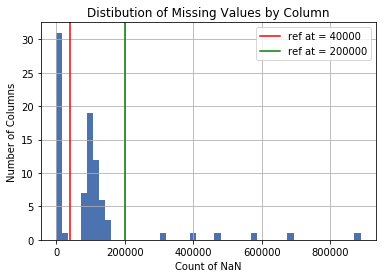


Dropping outlier columns from the dataset per limit.....
Number of columns in dropped list:  6
Before dropping:  (891221, 85)
After dropping:  (891221, 79)
(891221, 85)
(891221, 2)


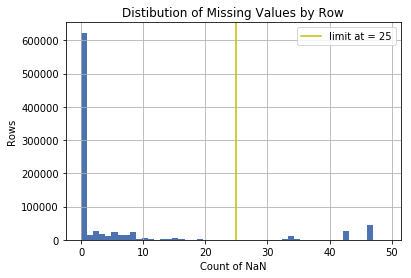


Dropping outlier rows from the dataset per limit.....

Before dropping:  (891221, 79)
Number of rows in dropped list:  93260
After dropping:  (797961, 79)
After dropping rows:  (797961, 79)

Number of multi categorical variables: 13 and Number of binary categorical variables: 5


Before Replacement:  ['W' 'O']
After Replacement:  [ 1.  0.]

before dummies (797961, 79)
after dummy column insertion (797961, 194)
adding new variables.. (797961, 194)
Shape after new variables:  (797961, 198)
   CAMEO_INTL_2015  CAMEO_Wealth  CAMEO_Lifestage
1             51.0           5.0              1.0
2             24.0           2.0              4.0
3             12.0           1.0              2.0
4             43.0           4.0              3.0
5             54.0           5.0              4.0
   PRAEGENDE_JUGENDJAHRE  Generation  Movement
1                   14.0        90.0       1.0
2                   15.0        90.0       2.0
3                    8.0        70.0       1.0
4                 

In [51]:
azdias_raw, feat_info = loadData() 
azdiasCleaned = clean_data1(azdias_raw,270000)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [52]:
def do_pca(n_components, df):
    start=timer()
    '''
    This is being borrowed from a helper function earlier in the class: 
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the scaled data 

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
            
    '''
    pca = PCA(n_components)
    df_pca = pca.fit_transform(df)
    end=timer() 
    print(f"Executed in {(end - start)/60:0.1f} minutes")
    return pca, df_pca

In [115]:
def do_standardized( df, myscaler):
    #INPUT: dataframe, the scaler type to use
    #OUTPUT: scaled data
    start=timer()  
    global scaledData 
    if myscaler == 1:
        scaler = StandardScaler() 
        scaledData = scaler.fit_transform(df)
        print ("Standard Scaler applied")
    elif myscaler == 2: 
         scaler = MinMaxScaler(feature_range=[0,1])
         scaledData = scaler.fit_transform(df)
         print ("MinMax Scaler applied")
    elif myscaler == 3:
        scaler = RobustScaler()
        scaledData = scaler.fit_transform(df)
        print ("Robust Scaler applied")
    else: 
        print ("Scaler not recognized")
    end=timer() 
    print(f"Executed in {(end - start)/60:0.1f} minutes")
    return scaler, scaledData 

In [54]:
#pca, Xpca = do_pca(194,azdiasCleaned,1)
#pickle.dump(pca,open('pca_std_194','wb'))

In [55]:
#pca1, Xpca1 = do_pca(194,azdiasCleaned,2)
#pickle.dump(pca1,open('pca_minmax_194','wb'))

In [56]:
#pca2, Xpca2 = do_pca(194,azdiasCleaned,3)
#pickle.dump(pca2,open('pca_robust_194','wb'))

In [57]:
#pca10, Xpca10 = do_pca(10,azdiasCleaned,3)
#pickle.dump(pca10,open('pca_robust_10','wb'))
#pickle.dump(Xpca10, open('Xpca10', 'wb'))

In [116]:
scaler, azdiasScaled = do_standardized(azdiasCleaned,3)

Robust Scaler applied
Executed in 0.5 minutes


In [117]:
azdiasPCA, azdiasXPCA = do_pca(25,azdiasScaled)
pickle.dump(azdiasPCA,open('azdias_std_25','wb'))
pickle.dump(azdiasXPCA, open('azdiasXPCA', 'wb'))

Executed in 0.5 minutes


In [60]:
oftype(azdiasXPCA)
azdiasXPCA[:1]

numpy


array([[-1.71969316,  0.74220805, -0.63248901,  2.0352418 ,  0.26327762,
         2.71088263, -1.23321645, -0.07948173,  0.2458282 , -1.07552921,
        -0.27664782,  1.15134095, -0.53088859,  0.09730408, -0.62689845,
        -1.59751948, -0.17896414, -1.2476633 , -1.41782284,  0.47566693,
        -1.46679944, -0.32327389, -0.34513443, -0.33428815, -0.32817522]])

In [61]:
#pca25, Xpca25 = do_pca(25,azdiasCleaned,3)
#pickle.dump(pca25,open('pca_robust_25','wb'))
#pickle.dump(Xpca25, open('Xpca25', 'wb'))

In [62]:
def loadPCA():
    pca = pickle.load(open('pca_std_194', 'rb'))
    pca1 = pickle.load(open('pca_minmax_194', 'rb'))
    pca2 = pickle.load(open('pca_robust_194', 'rb'))
    pca10 = pickle.load(open('pca_robust_10', 'rb'))
    Xpca10 = pickle.load(open("Xpca10", 'rb'))
    pca25 = pickle.load(open('pca_robust_25', 'rb'))
    Xpca25 = pickle.load(open("Xpca25", 'rb'))
    return pca, pca1, pca2, pca10, Xpca10, pca25, Xpca25

In [63]:
 #pca, pca1,pca2, pca10, Xpca10, pca25, Xpca25 = loadPCA()

In [64]:

print ("pca variance explained: %4.2f with %2d components "%(azdiasPCA.explained_variance_ratio_.sum(), azdiasPCA.n_components))

pca variance explained: 0.80 with 25 components 


In [65]:

def scree_plot(pca,pca1,pca2):
    '''
    Creates a scree plot associated with the principal components. Modifid from previous class helper fxn. 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    cumvals = np.cumsum(vals)
    
    num_components1 = len(pca1.explained_variance_ratio_)
    ind1 = np.arange(num_components1)
    vals1 = pca1.explained_variance_ratio_
    cumvals1 = np.cumsum(vals1)
    
    num_components2 = len(pca2.explained_variance_ratio_)
    ind2 = np.arange(num_components2)
    vals2 = pca2.explained_variance_ratio_
    cumvals2 = np.cumsum(vals2)
    
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
  
    #ax.bar(ind, vals)

    ax.plot(ind, cumvals, label = 'StandardScaler')
    ax.plot(ind1, cumvals1,label = 'MinMaxScaler')
    ax.plot(ind2, cumvals2,label = 'RobustScaler')
    
    ax.grid(True)
    plt.legend(loc='upper right')
    
    plt.xlim(0,200)
    #for i in range(num_components):
    #    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=1)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.axvline(25, linestyle='dashed', color='black')
    ax.axhline(0.8, linestyle='dashed', color='black')
 
    ax.set_facecolor("lightgray")
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.savefig('./plots/pca_scalers.png')
    plt.show() 

In [66]:
#scree_plot(pca,pca1,pca2)


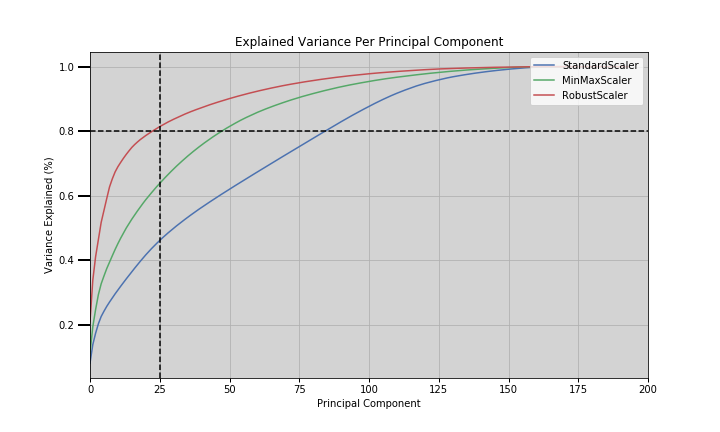

In [67]:
Image('./plots/pca_scalers.png')

In [68]:
# Apply feature scaling to the general population demographics data.


def scree_plot_bars(pca):
    # Creates a scree plot associated with the principal components. Modified from class example. 

    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    cumvals = np.cumsum(vals)
    
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
  
    ax.bar(ind, vals)
    ax.plot(ind, cumvals, label = 'RobustScaler')
   
    ax.grid(True)
    plt.legend(loc='upper right')
    
    plt.xlim(0,21)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10)
 
    ax.xaxis.set_tick_params(width=1)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.xticks(np.arange(0,21,step =2))
    plt.savefig('./plots/pca_bars.png')
    plt.show() 

In [69]:
#scree_plot_bars(azdiasPCA)

### Discussion 2.1: Apply Feature Scaling
An imputer was used to fill in for missing values. The 'most frequent' strategy was used. 
For feature scaling, 3 different scalers were applied: standard, minmax and robust. Robust gave a significantly better result - with 25 principle components, the amount was variation explained went from 50% for standard scaler to 80% for the robust scaler. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [70]:
# Investigate the variance accounted for by each principal component.
# See above

In [71]:
# Re-apply PCA to the data while selecting for number of components to retain.
# See above


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [72]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def pca_weights(pca, x):
    df = pd.DataFrame(pca.components_, columns=list(azdiasCleaned.columns))
    weights = df.iloc[x].sort_values(ascending=False)
    return weights

In [73]:
pca_weights_0 = pca_weights(azdiasPCA,0)
display (pca_weights_0.head(), pca_weights_0.tail())

MIN_GEBAEUDEJAHR      0.924715
PLZ8_ANTG1            0.076673
KONSUMNAEHE           0.070002
PLZ8_GBZ              0.065090
GEBAEUDETYP_RASTER    0.054198
Name: 0, dtype: float64

ORTSGR_KLS9           -0.075959
PLZ8_ANTG4            -0.079437
PLZ8_ANTG3            -0.084756
FINANZ_HAUSBAUER      -0.090618
ANZ_HAUSHALTE_AKTIV   -0.170107
Name: 0, dtype: float64

In [74]:
# Map weights for the second principal component to corresponding feature names
pca_weights_1 = pca_weights(azdiasPCA,1)
display (pca_weights_1.head(), pca_weights_1.tail())

ANZ_HAUSHALTE_AKTIV    0.418086
MIN_GEBAEUDEJAHR       0.320683
PLZ8_ANTG3             0.243733
PLZ8_BAUMAX            0.170976
PLZ8_ANTG4             0.170361
Name: 1, dtype: float64

ANZ_PERSONEN     -0.145827
KBA05_GBZ        -0.154407
PLZ8_GBZ         -0.224827
PLZ8_ANTG1       -0.248166
WOHNDAUER_2008   -0.265844
Name: 1, dtype: float64

In [75]:
# Map weights for the third principal component to corresponding feature names
pca_weights_2 = pca_weights(azdiasPCA,2)
display (pca_weights_2.head(), pca_weights_2.tail())

WOHNDAUER_2008          0.671420
ANZ_HAUSHALTE_AKTIV     0.246865
ALTERSKATEGORIE_GROB    0.150495
MIN_GEBAEUDEJAHR        0.150300
SEMIO_ERL               0.138097
Name: 2, dtype: float64

FINANZ_SPARER   -0.139024
SEMIO_TRADV     -0.153822
SEMIO_PFLICHT   -0.165036
SEMIO_RAT       -0.182650
SEMIO_REL       -0.268277
Name: 2, dtype: float64

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [76]:
#azdias_clean, pca10, Xpca10 = restart()

In [77]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [78]:
def scree_KMeans_plot(data):
    scores = [] 
    k_values = []
    start = timer()
    for k in range(1,15):
        k_values.append(k)
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(data)
        labels = kmeans.predict(data)
        score = -(kmeans.score(data))
        scores.append(score)
      
    plt.plot(k_values, scores, marker = 'o')
    plt.ylabel('K-Cluster Score')
    plt.xlabel('k value')
    plt.title('Number of Clusters vs KMeans Score')
    plt.savefig('Cluster_vs_score_plot.png')
    end = timer() 
    print(f"\nFunction in {(end - start)/60:0.1f} minutes")
    plt.show()

In [79]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

#scree_KMeans_plot(azdiasXPCA)

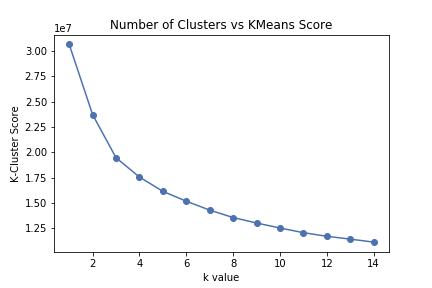

In [80]:
#display 'Cluster_vs_score_plot.png'
Image('Cluster_vs_score_plot.png')

In [81]:
def silhouetteScore(df): 
    range_n_clusters = list(range(2,11))
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = kmeans.fit_predict(df)
        score = silhouette_score(df,cluster_labels)
        print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

In [82]:
def azdiasCleanup():
    # release dataframes to free memory: 
    try: 
        del azdiasCleaned 
    except NameError: 
        print ("dataframe azdiasCleaned does not exist")

    try: 
        del azdias 
    except NameError: 
        print ("dataframe azdias does not exist")

    try: 
        del azdias_raw 
    except NameError: 
        print ("dataframe azdias_raw does not exist")

    print ("\ncollecting garbage")
    gc.collect()


In [83]:
#azdiasCleanup()

In [84]:
#silhouetteScore(azdiasXPCA)

In [85]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
start = timer()
kmeans = KMeans(n_clusters=10)
azdiasLabels = kmeans.fit_predict(azdiasXPCA)
end = timer() 
print(f"Function executed in {(end - start)/60:0.1f} minutes")

Function executed in 2.6 minutes


In [86]:
oftype(azdiasLabels)
print (azdiasLabels.shape)
print (azdiasLabels[:20])
display (set(azdiasLabels))
#print ("max: ",azdiasLabels.max(), "min: ",azdiasLabels.min())

numpy
(797961,)
[3 1 8 4 1 1 1 7 5 9 2 2 5 5 5 5 8 3 5 5]


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [87]:
clusterDict = collections.Counter(azdiasLabels)
print (clusterDict)

customerClusterSum = sum(clusterDict.values())

for key,value in sorted(clusterDict.items()): 
    print (key, ' ->',np.round(100*value/customerClusterSum,2),'%')
  

Counter({7: 138263, 9: 136868, 4: 109965, 5: 104504, 1: 95988, 3: 87138, 8: 49967, 0: 46493, 2: 24455, 6: 4320})
0  -> 5.83 %
1  -> 12.03 %
2  -> 3.06 %
3  -> 10.92 %
4  -> 13.78 %
5  -> 13.1 %
6  -> 0.54 %
7  -> 17.33 %
8  -> 6.26 %
9  -> 17.15 %


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [88]:
# Load in the customer demographics data.
# Load in the general demographics and feature summary file. 
def loadCustomerData(): 
    print ("\nLoading Data....")
    missing_values_azdias = ['-1',"''",'X','XX']
    customer = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';', na_values = missing_values_azdias)
    print ("Data loaded.")
    return customer

In [89]:
customer = loadCustomerData()


Loading Data....
Data loaded.



Converting feat_info missing value strings to float....

Replacing dataframe missing values with np.nan...
(191652, 85)

Counting the number of missing values per column....


,Column Name,Count_NaN
40,TITEL_KZ,189340
47,KK_KUNDENTYP,111937
64,KBA05_BAUMAX,109535


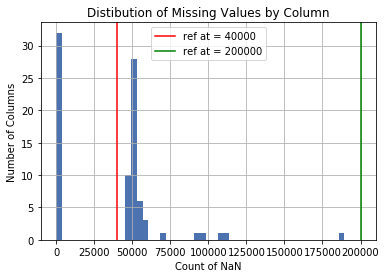


Dropping outlier columns from the dataset per limit.....
Number of columns in dropped list:  5
Before dropping:  (191652, 85)
After dropping:  (191652, 80)
(191652, 85)
(191652, 2)


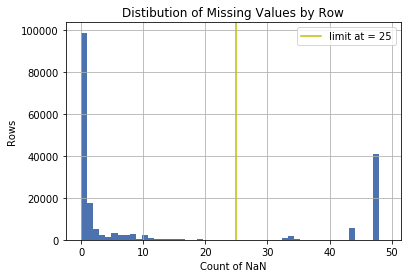


Dropping outlier rows from the dataset per limit.....

Before dropping:  (191652, 80)
Number of rows in dropped list:  49943
After dropping:  (141709, 80)
After dropping rows:  (141709, 80)

Number of multi categorical variables: 13 and Number of binary categorical variables: 5


Before Replacement:  ['W' 'O']
After Replacement:  [ 1.  0.]

before dummies (141709, 80)
after dummy column insertion (141709, 194)
adding new variables.. (141709, 194)
Shape after new variables:  (141709, 198)
   CAMEO_INTL_2015  CAMEO_Wealth  CAMEO_Lifestage
0             13.0           1.0              3.0
2             34.0           3.0              4.0
3             24.0           2.0              4.0
4             41.0           4.0              1.0
5             34.0           3.0              4.0
   PRAEGENDE_JUGENDJAHRE  Generation  Movement
0                    4.0        50.0       2.0
2                    4.0        50.0       2.0
3                    1.0        40.0       1.0
4                 

In [90]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customerCleaned = clean_data1(customer,75000) 

In [91]:
def matchColumns(df1,df2) :
     print ("Shape of df1: ",df1.shape, "Shape of df2: ",df2.shape)
     df1_unique_columns = list(set(df1.columns) - set(df2.columns))
     print ("Unique df1 columns:): ",  df1_unique_columns)
     df2_unique_columns = list(set(df2.columns) - set(df1.columns))
     print ("Unmatched columns1 are (missing in azdias): ",df2_unique_columns)
     if set(df1_unique_columns).issubset(df1.columns):
        print("\nNumber of Columns in df1 database: ",df1.shape[1]) 
        print ("Dropping columns in df1...")
        df1 = df1.drop(df1_unique_columns, axis = 1)
     if set(df2_unique_columns).issubset(df2.columns):
        print("Number of Columns in df2 database: ",df2.shape[1])
        print ("Dropping columns {} in df2 (customer)...".format(df2_unique_columns))
        df2 = df2.drop(df2_unique_columns, axis = 1)
     print ("New Shape of df1: ",df1.shape, "New Shape of df2: ",df2.shape)
         
     check_unmatchedColumns = list(set(df1.columns) - set(df2.columns))
     print ("Post Unmatched columns are: ",check_unmatchedColumns)
     return df1,df2

In [92]:
azdiasMatched, customerMatched = matchColumns(azdiasCleaned, customerCleaned)

Shape of df1:  (797961, 196) Shape of df2:  (141709, 196)
Unique df1 columns:):  ['GEBAEUDETYP_5.0']
Unmatched columns1 are (missing in azdias):  ['ALTER_HH']

Number of Columns in df1 database:  196
Dropping columns in df1...
Number of Columns in df2 database:  196
Dropping columns ['ALTER_HH'] in df2 (customer)...
New Shape of df1:  (797961, 195) New Shape of df2:  (141709, 195)
Post Unmatched columns are:  []


In [93]:
# Redo azdias PCA with matched columns
azdiasPCA_matched,azdiasXPCA_matched = do_pca(25,azdiasMatched)

Executed in 1.1 minutes


In [94]:
# Get customer PCA components using azdias model 
customerPCA = azdiasPCA_matched.transform(customerMatched)

In [95]:
# Redo KMeans with matched columns 
kmeans = KMeans(n_clusters=10)
azdiasLabels = kmeans.fit_predict(azdiasXPCA_matched)

In [96]:
clusterDict = collections.Counter(azdiasLabels)
print (clusterDict)

customerClusterSum = sum(clusterDict.values())

for key,value in sorted(clusterDict.items()): 
    print (key, ' ->',np.round(100*value/customerClusterSum,2),'%')

Counter({4: 157542, 7: 144854, 2: 137428, 8: 100970, 0: 84609, 6: 68994, 1: 47811, 3: 38989, 9: 12547, 5: 4217})
0  -> 10.6 %
1  -> 5.99 %
2  -> 17.22 %
3  -> 4.89 %
4  -> 19.74 %
5  -> 0.53 %
6  -> 8.65 %
7  -> 18.15 %
8  -> 12.65 %
9  -> 1.57 %


In [97]:
customerLabels = kmeans.predict(customerPCA)

In [98]:
clusterDict = collections.Counter(customerLabels)
print (clusterDict)

customerClusterSum = sum(clusterDict.values())

for key,value in sorted(clusterDict.items()): 
    print (key, ' ->',np.round(100*value/customerClusterSum,2),'%')

Counter({4: 28817, 2: 26490, 7: 22015, 8: 20462, 6: 14088, 1: 10262, 0: 9110, 3: 6960, 9: 2659, 5: 846})
0  -> 6.43 %
1  -> 7.24 %
2  -> 18.69 %
3  -> 4.91 %
4  -> 20.34 %
5  -> 0.6 %
6  -> 9.94 %
7  -> 15.54 %
8  -> 14.44 %
9  -> 1.88 %


In [99]:
print (customerPCA.shape)
print (customerLabels.shape)
print (set(customerLabels))
#scaler = StandardScaler()
#print (scaler.inverse_transform(customer_pca.inverse_transform(kmeans.cluster_centers_)))

(141709, 25)
(141709,)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [100]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
def proportions(df,name): 
    clusterDict = collections.Counter(df)
    clusterSum = sum(clusterDict.values())
    for key,value in sorted(clusterDict.items()): 
        #print (key, ' ->',np.round(100*value/customerClusterSum,2),'%')
        clusterDict[key] = np.round(value/clusterSum,2)
    clusterDict = pd.DataFrame(list(clusterDict.items()),columns = ['Cluster','Proportion'])
    clusterDict['Population'] = name
    return clusterDict

In [101]:
generalProportions = proportions(azdiasLabels,'General')
customerProportions = proportions(customerLabels,'Customers')
all = pd.concat([generalProportions, customerProportions])
all

,Cluster,Proportion,Population
0,6,0.09,General
1,8,0.13,General
2,2,0.17,General
3,4,0.20,General
4,3,0.05,General
5,1,0.06,General
6,7,0.18,General
7,0,0.11,General
8,9,0.02,General
9,5,0.01,General


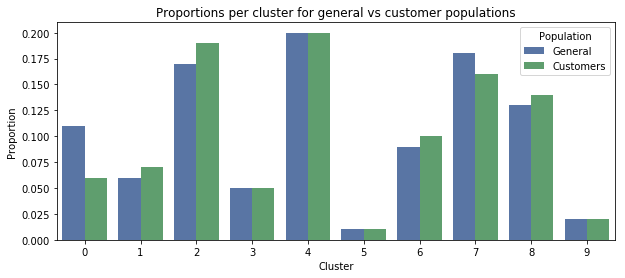

In [102]:
#fig, ax = plt.subplots(2,3, sharex=True,sharey=True,figsize=(14,4),gridspec_kw={'hspace': 0.3})
fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(ax=ax, x=all.Cluster, y = all.Proportion, hue=all.Population)
#sns.barplot(ax=ax, x=customerProportions.Cluster, y = customerProportions.Proportion, hue=customerProportions.Population)
ax.set_xlabel('Cluster')
ax.set_title('Proportions per cluster for general vs customer populations');    


In [103]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
all = pd.concat([generalProportions, customerProportions])
all = all.sort_values(by=['Cluster','Population'],ascending = (True,False))
all['difference'] = all.groupby(['Cluster'])['Proportion'].diff()
all = all.dropna()
print ('Customers that are over represented come from the below clusters:')
all = all[all.difference > 0.0]
overRepresented = all[['Cluster','difference']]
overRepresented.insert(2,'Customers','overRepresented')
overRepresented


Customers that are over represented come from the below clusters:


,Cluster,difference,Customers
0,1,0.01,overRepresented
4,2,0.02,overRepresented
8,6,0.01,overRepresented
2,8,0.01,overRepresented


In [104]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

all = pd.concat([generalProportions, customerProportions])
all = all.sort_values(by=['Cluster','Population'],ascending = (True,False))
all['difference'] = all.groupby(['Cluster'])['Proportion'].diff()
all = all.dropna()
print ('Customers that are under represented come from the below clusters:')
all = all[all.difference < 0.0]
underRepresented = all[['Cluster','difference']]
underRepresented.insert(2,'Customers','underRepresented')
underRepresented

Customers that are under represented come from the below clusters:


,Cluster,difference,Customers
6,0,-0.05,underRepresented
7,7,-0.02,underRepresented


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

In [105]:
azdiasCleanup()

dataframe azdiasCleaned does not exist
dataframe azdias does not exist
dataframe azdias_raw does not exist

collecting garbage


In [109]:
pca_cluster=azdiasXPCA[azdiasLabels == 1]
#standardized_features = azdiasPCA_matched.inverse_transform(azdiasXPCA)

In [118]:
standardized_features = azdiasPCA.inverse_transform(pca_cluster)

In [120]:
features_cluster1 = scaler.inverse_transform(standardized_features)

In [121]:
features_cluster1 = pd.DataFrame(np.round(features_cluster1), columns = azdias.columns)

In [107]:
endProgram = timer() 
print(f"Executed in {(endProgram - startProgram)/60:0.1f} minutes")

Executed in 10.1 minutes


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.